In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.utils.data as Data
import math, copy, time
import matplotlib.pyplot as plt
import pandas as pd
from model.Transformer import Transformer
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import pickle
from utils import *
%matplotlib inline
torch.set_printoptions(precision=8)

In [2]:
# init paramters
seed = 100
batch_size = 16
learning_rate = 1e-6
n_child_features = 5

# steup using GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
time_step = 40

# Transformer Parameters
d_ff = 500              # the number of hidden layer neurons from FeedForward neural network
d_k = d_v = 64          # dimension of K(=Q), V
n_layers = 6            # number of Encoder of Decoder Layer
n_heads = 8             # number of heads in Multi-Head Attention
tgt_vocab_size = 1

set_rand_seed(seed)

Random Seed:  100


In [3]:
# load FinTech data
df = pd.read_csv('./data/FinTech.csv', encoding='utf-8', header=0)
df.describe()

,DXYUSD_Open,DXYUSD_High,DXYUSD_Low,DXYUSD_Close,DXYUSD_AdjClose,World_Index_Open,World_Index_High,World_Index_Low,World_Index_Close,World_Index_AdjClose,...,VIX_Low,VIX_Close,VIX_AdjClose,TNXTbill_Open,TNXTbill_High,TNXTbill_Low,TNXTbill_Close,TNXTbill_AdjClose,sentiment,Return
count,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,...,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000
mean,93.037063,93.341670,92.764299,93.058869,93.058869,79.970728,80.308838,79.539733,79.929832,74.090235,...,15.988079,16.802382,16.802382,2.146808,2.170868,2.122675,2.146971,2.146971,0.133745,0.004072
std,6.428785,6.444130,6.371380,6.411762,6.411762,11.206009,11.210723,11.210554,11.216312,13.695053,...,6.757086,7.519748,7.519748,0.639077,0.637051,0.639492,0.637137,0.637137,0.048497,0.048865
min,79.139999,79.239998,78.910004,79.139999,79.139999,59.000000,59.000000,58.980000,59.000000,50.273331,...,8.840000,9.140000,9.140000,0.484000,0.538000,0.398000,0.499000,0.499000,-0.238979,-0.351903
25%,90.322500,90.617498,90.070000,90.362501,90.362501,71.122501,71.379997,70.702497,71.045000,62.914810,...,12.252500,12.642500,12.642500,1.817250,1.845000,1.790750,1.815500,1.815500,0.102053,-0.015518
50%,95.180000,95.524998,94.924999,95.169998,95.169998,76.445003,76.895001,75.950000,76.559998,70.956318,...,13.865000,14.460000,14.460000,2.271500,2.295000,2.245500,2.268000,2.268000,0.125821,0.002161
75%,97.427500,97.687502,97.160004,97.419998,97.419998,89.180000,89.477502,88.697498,89.145001,84.892201,...,17.237500,18.407500,18.407500,2.610750,2.633250,2.585750,2.605750,2.605750,0.160976,0.022501
max,103.260002,103.820000,103.029999,103.290001,103.290001,112.940002,112.940002,112.050003,112.139999,112.139999,...,70.370003,82.690002,82.690002,3.239000,3.248000,3.233000,3.234000,3.234000,0.646698,0.369460


In [4]:
# Divide the data set into inputs and outputs
df_input = df.drop(['Return'], axis=1).values[:, :]
df_ouput = df[['Return']].values

# df_input = df.drop(['BTC_Price'], axis=1).values
# df_ouput = df[['BTC_Price']].values

n_samples, n_features = df_input.shape[0], df_input.shape[-1]
print(df_input.shape, df_ouput.shape)


# split data to train and test set
# X_train, X_test, Y_train, Y_test = train_test_split(df_input, df_ouput, test_size=0.2, random_state=1, shuffle=True)
n_train = int(n_samples * 0.8)
X_train, X_test = df_input[:n_train], df_input[n_train:]
Y_train, Y_test = df_ouput[:n_train], df_ouput[n_train:]


# # Normalized data (mean:0, std:1)
X_train_scaler = StandardScaler()
Y_train_scaler = StandardScaler()
X_test_scaler = StandardScaler()
Y_test_scaler = StandardScaler()

X_train = X_train_scaler.fit_transform(X_train)
X_test = X_test_scaler.fit_transform(X_test)
Y_train = Y_train_scaler.fit_transform(Y_train)
Y_test = Y_test_scaler.fit_transform(Y_test)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

# built timeseries data for LSTM
X_train, Y_train = time_sequence(X_train, Y_train, time_step=time_step)
X_test, Y_test = time_sequence(X_test, Y_test, time_step=time_step)

# make DataLoader for train and evaluation
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size, shuffle=False)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1910, 51) (1910, 1)
(1528, 51) (1528, 1) (382, 51) (382, 1)
torch.Size([1489, 40, 51]) torch.Size([1489, 1]) torch.Size([343, 40, 51]) torch.Size([343, 1])


In [5]:
# 'R2 score'
def accuracy1(preds, y):
    SSE = torch.sum(torch.square(y - preds))
    SST = torch.sum(torch.square(y - torch.mean(y)))
    return 1 - (SSE/SST)

def accuracy2(preds, y):
    SSR = torch.sum(torch.square(preds - torch.mean(y)))
    SST = torch.sum(torch.square(y - torch.mean(y)))
    return (SSR/SST)
# adjust R2 score
# def accuracy(preds, y):
#     n = preds.size(0)
#     SSE = torch.sum(torch.square(y - preds))
#     SST = torch.sum(torch.square(y - torch.mean(y)))
#     return 1-((n-1)/(n-n_features))*(SSE/SST)

# def accuracy(preds, y):
#     n = preds.size(0)
#     SSR = torch.sum(torch.square(preds - torch.mean(y)))
#     SST = torch.sum(torch.square(y - torch.mean(y)))
#     return 1-(1-SSR/SST)*(n-1)/(n-n_features-1)

def train(model, iterator, optimizer, criteon):

    avg_loss = []
    avg_acc = []
    model.train() 

    for batch_id, batch_data in enumerate(iterator):
        
        inputs, labels = batch_data
        
        dec_inputs = torch.zeros(labels.size(0), labels.size(-1), 1).long().cuda()
        inputs = inputs.to(device)
        labels = labels.to(device)
        pred, enc_self_attns, dec_self_attns, dec_enc_attns = model(inputs, dec_inputs)
        
#         print(pred.squeeze().shape, labels.shape)
        loss = criteon(pred.squeeze(), labels.squeeze())
        acc = accuracy2(pred.squeeze(), labels.squeeze()).item()
        
        avg_loss.append(loss.item())
        avg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        dec_inputs = dec_inputs.cpu()
        torch.cuda.empty_cache()

    avg_acc = np.array(avg_acc).mean()
    avg_loss = np.array(avg_loss).mean()
    return avg_loss, avg_acc
def predict(model, X):
    model.eval()
#     dec_inputs = torch.zeros(labels.size(0), labels.size(-1), 1).long().to(device)
    dec_inputs = torch.zeros(X.size(0), 1, 1).long().to(device)
    X = X.to(device)
    pred, enc_self_attns, dec_self_attns, dec_enc_attns = model(X, dec_inputs)
    dec_inputs = dec_inputs.cpu()
    return pred


def evaluate(model, iterator, criteon):
    avg_loss = []
    avg_acc = []
    model.eval()
    att_weights = []
    with torch.no_grad():
        for batch_data in iterator:
            
            inputs, labels = batch_data
            dec_inputs = torch.zeros(labels.size(0), labels.size(-1), 1).long().cuda()
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred, enc_self_attns, dec_self_attns, dec_enc_attns = model(inputs, dec_inputs)
            
#             att_weights.append(attention_weight.squeeze())
            loss = criteon(pred.squeeze(), labels.squeeze())
            acc = accuracy2(pred, labels).item()

            avg_loss.append(loss.item())
            avg_acc.append(acc)
            dec_inputs = dec_inputs.cpu()
            torch.cuda.empty_cache()

    avg_loss = np.array(avg_loss).mean()
    avg_acc = np.array(avg_acc).mean()
    return avg_loss, avg_acc, enc_self_attns, dec_self_attns, dec_enc_attns


Epoch:  1 | Epoch Time: 0.0m 8.71s
	Train Loss: 1.037292 | Train Acc: inf%
	 Val. Loss: 0.979575 |  Val. Acc: 21.00870%


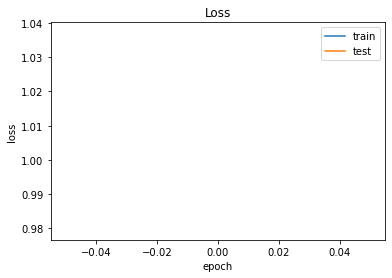

Epoch: 51 | Epoch Time: 0.0m 8.86s
	Train Loss: 0.964276 | Train Acc: inf%
	 Val. Loss: 0.938176 |  Val. Acc: 13.40564%
Epoch: 101 | Epoch Time: 0.0m 8.89s
	Train Loss: 0.986196 | Train Acc: inf%
	 Val. Loss: 0.934587 |  Val. Acc: 13.53247%
Epoch: 151 | Epoch Time: 0.0m 9.04s
	Train Loss: 0.963814 | Train Acc: inf%
	 Val. Loss: 0.928465 |  Val. Acc: 14.05206%
Early Stoping!!
Epoch: 166 | Epoch Time: 0.0m 8.96s
	Train Loss: 1.000821 | Train Acc: inf%
	 Val. Loss: 0.929745 |  Val. Acc: 14.58492%


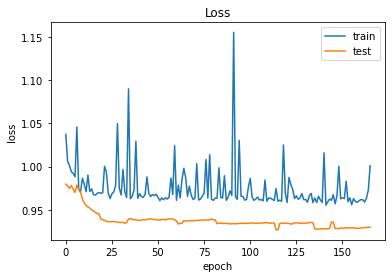

In [6]:
# built Transformer model
model = Transformer(n_heads, time_step, n_features, d_ff, n_layers, d_k, d_v, n_child_features).cuda()
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
# optimizer_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=20, T_mult=10, eta_min=0)

warmup_epochs = 10
warmup_scheduler = WarmUpLR(optimizer, warmup_epochs)
optimizer_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=500,eta_min=0, last_epoch=-1)

#train and print model
best_valid_acc = float('-inf')

enc_self_attentions = []
dec_self_attentions = []
dec_enc_attentions = []

early_stoping_iters = 50
count = 0
epochs = 1000
loss_train = []
loss_test = []
eastop = False
min_loss = 1e8
early_stoping_start = 100

for epoch in range(epochs):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    dev_loss, dev_acc, enc_self_attns, dec_self_attns, dec_enc_attns = evaluate(model, test_loader, criterion)
    
    
    end_time = time.time()
#     optimizer_scheduler.step()
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        optimizer_scheduler.step()
        
    loss_train.append(train_loss)
    loss_test.append(dev_loss)
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
    
    if epoch > early_stoping_start and dev_loss < min_loss:
        min_loss = dev_loss
    if dev_loss > min_loss and epoch > early_stoping_start:
        count+=1
    else:
        count=0
    if count == early_stoping_iters:
        print("Early Stoping!!")
        eastop = True

    if dev_loss <= min(loss_test): 
        torch.save(model.state_dict(), './model/transformer-model.pt')
    if epoch % 50 == 0 or epoch == epochs-1 or eastop:
        print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.6f} | Train Acc: {train_acc*100:.5f}%')
        print(f'\t Val. Loss: {dev_loss:.6f} |  Val. Acc: {dev_acc*100:.5f}%')
    enc_self_attentions.append(enc_self_attns)
    dec_enc_attentions.append(dec_enc_attns)
    dec_self_attentions.append(dec_self_attns)
    if count == early_stoping_iters:
        break
    if epoch % 200 == 0:
        plot_loss(loss_train, loss_test)
plot_loss(loss_train, loss_test)

In [7]:
# #use srored model to predice 
model.load_state_dict(torch.load("./model/transformer-model.pt"))
# test_loss, test_acc, att_weights = evaluate(model, test_iterator, criteon)
# print(f'Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')

<All keys matched successfully>

In [20]:
train_pre_list = []
test_pre_list = []
for i in range(X_train.shape[0]):
    train_pre = predict(model, X_train[i].reshape(1,time_step,-1))
    train_pre_list.append(train_pre.cpu().detach().numpy())
for i in range(X_test.shape[0]):
    test_pre = predict(model, X_test[i].reshape(1,time_step,-1))
    test_pre_list.append(test_pre.cpu().detach().numpy())
train_pre = np.vstack(train_pre_list)
test_pre = np.vstack(test_pre_list)

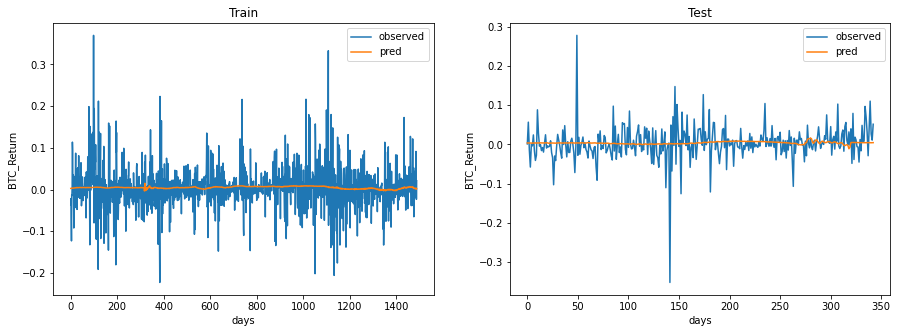

tensor(0.00671101) tensor(0.00295321) 0.0023940955 0.0024280166935990543
tensor(-0.00278795) tensor(0.00451768) 0.0018770476 0.0018876739181181495


In [25]:
# inverse normalized
# train_pre = predict(model, X_train[:100])
# test_pre = predict(model, X_test[:100])

# print(criterion(train_pre, Y_train), criterion(test_pre, Y_test))
train_pre = Y_train_scaler.inverse_transform(train_pre)
yytrain = Y_train_scaler.inverse_transform(Y_train)
test_pre = Y_test_scaler.inverse_transform(test_pre)
yytest = Y_test_scaler.inverse_transform(Y_test)


# plot prediction and true values
#进行绘图
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(yytrain)
plt.plot(train_pre)
plt.xlabel('days')
plt.ylabel('BTC_Return')
plt.legend(['observed', 'pred'])
plt.title('Train')
plt.subplot(122)
plt.plot(yytest)
plt.plot(test_pre)
plt.xlabel('days')
plt.ylabel('BTC_Return')
plt.legend(['observed', 'pred'])
plt.title('Test')
plt.show()


from sklearn.metrics import mean_squared_error
print(accuracy1(torch.Tensor(train_pre), torch.Tensor(yytrain)), accuracy2(torch.Tensor(train_pre), torch.Tensor(yytrain)), 
      mean_squared_error(train_pre, yytrain), mean_squared_error(np.zeros([yytrain.shape[0], 1]), yytrain))
print(accuracy1(torch.Tensor(test_pre), torch.Tensor(yytest)), accuracy2(torch.Tensor(test_pre), torch.Tensor(yytest)),
      mean_squared_error(test_pre, yytest),  mean_squared_error(np.zeros([yytest.shape[0], 1]), yytest))

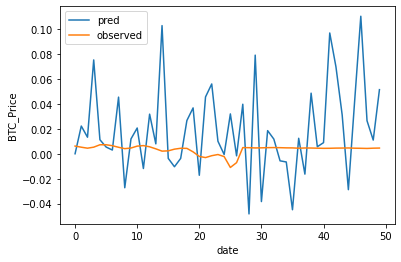

In [26]:
# plot prediction and true values
plt.plot(yytest[-50:])
plt.plot(test_pre[-50:])
plt.xlabel('date')
plt.ylabel('BTC_Price')
plt.legend(['pred','observed'])
plt.show()

In [28]:
# dy / dx
import copy
delta_x = 1e-5
print(X_test.shape)
cols = df.columns[:-1]
newcols = []
dy = []
i = 0
while i < X_test.shape[-1]:
    new_X_test = copy.deepcopy(X_test)
    if i < 50:
        new_X_test[:, :, i:i+5] += delta_x
        newcols.append(''.join(cols[i].split('_')[0])+ '_aggregation')
        i += 5
    else:
        new_X_test[:, :, i] += delta_x
        newcols.append(cols[i])
        i += 1
#     new
    train_pre_list = []
    test_pre_list = []
    for j in range(X_train.shape[0]):
        train_pre = predict(model, X_train[j].reshape(1,time_step,-1))
        train_pre_list.append(train_pre.cpu().detach().numpy())
    for i in range(X_test.shape[0]):
        test_pre = predict(model, X_test[j].reshape(1,time_step,-1))
        test_pre_list.append(test_pre.cpu().detach().numpy())
    train_pre = np.vstack(train_pre_list)
    test_pre = np.vstack(test_pre_list)
#     print((y1 - y0).cpu().detach().numpy())
    dy.append(((y1 - y0).cpu().detach().numpy() / delta_x).reshape(-1))
dy = np.array(dy).T
dy.mean(axis=0)

# dev_loss, dev_acc, att_weights = evaluate(model, test_loader, criteon)
# att = torch.cat(att_weights, dim=0).cpu()
# pd.DataFrame(att.numpy().sum(axis=0).reshape(-1, 1))
df_coef = pd.DataFrame(columns=['variable', 'coefficient'])
df_coef['variable'] = newcols
df_coef['coefficient'] = dy.mean(axis=0)
df_coef['class'] = df_coef['variable'].apply(lambda x:x.split('_')[0])
df_coef['abs_coefficient'] = df_coef['coefficient'].abs()
# sort by absolute value of coefficient
df_agg_coef = df_coef.groupby(by='class').mean()
df_agg_coef = df_agg_coef.reset_index()
df_agg_coef.sort_values(by='abs_coefficient', ascending=False)[:15].reset_index(drop=True)
df_coef.sort_values(by='abs_coefficient', ascending=False)[:30].reset_index(drop=True)[['variable', 'coefficient', 'abs_coefficient']]

torch.Size([343, 40, 51])


,variable,coefficient,abs_coefficient
0,sentiment,-0.062312,0.062312
1,DBCCommodity_aggregation,-0.040393,0.040393
2,VIX_aggregation,-0.010292,0.010292
3,CrudeOil_aggregation,0.006852,0.006852
4,TNXTbill_aggregation,0.004830,0.004830
5,DXYUSD_aggregation,0.001428,0.001428
6,GoldUSD_aggregation,-0.001157,0.001157
7,SPY_aggregation,-0.000951,0.000951
8,DJCI_aggregation,-0.000122,0.000122
9,World_aggregation,0.000000,0.000000


In [29]:
# # save to res
# # load result
if os.path.exists('./result/Transformer_result.pkl'):
    res = pickle.load(open('./result/Transformer_result.pkl', 'rb'))
else:
    res = {}
# res = {}
info = {}
info['Describe'] = 'Only price inforamtion was used to predict Return with timestep 5'
info['Variables'] = newcols
info['Model_Parameters'] = {'lr':learning_rate, 'L2':1e-5, 'epochs':epochs, 'batch_size':batch_size, 'hidden_size':d_ff, 'layers':n_layers, 'd_k':d_k}
info['R2score'] = {'accuracy1':[accuracy1(torch.Tensor(train_pre), torch.Tensor(yytrain)), accuracy1(torch.Tensor(test_pre), torch.Tensor(yytest))], 
                   'accuracy2':[accuracy2(torch.Tensor(train_pre), torch.Tensor(yytrain)), accuracy2(torch.Tensor(test_pre), torch.Tensor(yytest))]}
info['Timestep'] = time_step
info['MeanSquaredError'] = [mean_squared_error(train_pre, yytrain), mean_squared_error(test_pre, yytest)]
info['Coefficient'] = dy.mean(axis=0)
# res['Transformer_'+str(len(res))] = info
res['Transformer_'+str(len(res))] = info
# save result
with open('./result/Transformer_result.pkl', 'wb') as f:
    pickle.dump(res, f)
res

{'Transformer_0': {'Describe': 'Only price inforamtion was used to predict Return',
  'Variables': ['DXYUSD_aggregation',
   'World_aggregation',
   'GoldUSD_aggregation',
   'Silver_aggregation',
   'DBCCommodity_aggregation',
   'DJCI_aggregation',
   'CrudeOil_aggregation',
   'SPY_aggregation',
   'VIX_aggregation',
   'TNXTbill_aggregation',
   'sentiment'],
  'Model_Parameters': {'lr': 1e-06,
   'L2': 1e-05,
   'epochs': 1000,
   'batch_size': 64,
   'hidden_size': 500,
   'LSTM_layers': 6,
   'd_k': 64},
  'R2score': {'accuracy1': [tensor(0.00420159), tensor(-0.00032580)],
   'accuracy2': [tensor(0.00154160), tensor(0.00128833)]},
  'Timestep': 20,
  'MeanSquaredError': [0.0023997133, 0.0018530792],
  'Coefficient': array([-1.8062013e-04, -1.9704015e-04,  7.5942560e-05,  0.0000000e+00,
         -3.0128671e-02,  2.1961766e-04,  6.4561442e-03, -1.1206658e-03,
         -1.0222484e-02,  3.1670099e-03, -3.7876863e-02], dtype=float32)},
 'Transformer_1': {'Describe': 'Only price infor